In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.ensemble import IsolationForest
from IPython.display import display, HTML
from sklearn.preprocessing import (
    PowerTransformer,
    OneHotEncoder,
    StandardScaler
)
from scipy import stats
import statsmodels.api as sm


## Read the train dataset

In [3]:
train = pd.read_csv(r"C:\Users\skaur\OneDrive\Desktop\Flight Price Prediction Dataset\data\train.csv")

In [4]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-24,Banglore,Delhi,16:55:00,19:55:00,180,0.0,No Info,4823
1,Spicejet,2019-06-09,Delhi,Cochin,06:05:00,11:20:00,315,1.0,No Info,5583
2,Indigo,2019-06-15,Delhi,Cochin,05:05:00,16:10:00,665,1.0,No Info,6818
3,Jet Airways,2019-05-01,Kolkata,Banglore,14:05:00,23:35:00,570,1.0,No Info,14781
4,Jet Airways,2019-03-24,Kolkata,Banglore,21:10:00,20:40:00,1410,1.0,No Info,13759
...,...,...,...,...,...,...,...,...,...,...
1275,Jet Airways,2019-05-06,Kolkata,Banglore,20:00:00,08:15:00,735,1.0,No Info,14388
1276,Jet Airways,2019-05-01,Mumbai,Hyderabad,19:35:00,21:05:00,90,0.0,In-flight meal not included,2228
1277,Jet Airways,2019-06-03,Delhi,Cochin,13:00:00,19:00:00,360,1.0,No Info,14714
1278,Multiple Carriers,2019-05-18,Delhi,Cochin,08:30:00,19:15:00,645,1.0,No Info,7887


In [5]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [6]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst=True)
    for col in ["date_of_journey", "dep_time", "arrival_time"]
})

C:\Users\skaur\AppData\Local\Temp\ipykernel_22696\2836568496.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  col: pd.to_datetime(train.loc[:, col], dayfirst=True)
C:\Users\skaur\AppData\Local\Temp\ipykernel_22696\2836568496.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(train.loc[:, col], dayfirst=True)
C:\Users\skaur\AppData\Local\Temp\ipykernel_22696\2836568496.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(train.loc[:, col], dayfirst=True)


In [7]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          1280 non-null   object        
 1   date_of_journey  1280 non-null   datetime64[ns]
 2   source           1280 non-null   object        
 3   destination      1280 non-null   object        
 4   dep_time         1280 non-null   datetime64[ns]
 5   arrival_time     1280 non-null   datetime64[ns]
 6   duration         1280 non-null   int64         
 7   total_stops      1280 non-null   float64       
 8   additional_info  1280 non-null   object        
 9   price            1280 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 100.1+ KB


In [9]:
train.describe(include='number')

,duration,total_stops,price
count,1280.000000,1280.000000,1280.000000
mean,632.796875,0.809375,9050.713281
std,499.074348,0.676587,4609.259472
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5117.750000
50%,520.000000,1.000000,8328.500000
75%,925.000000,1.000000,12410.250000
max,2245.000000,4.000000,62427.000000


In [10]:
train.describe(include='O')

,airline,source,destination,additional_info
count,1280,1280,1280,1280
unique,8,5,6,6
top,Jet Airways,Delhi,Cochin,No Info
freq,439,528,528,1023


In [11]:
(
    train.assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,1280,1280,1280,1280.0,1280
unique,8,5,6,5.0,6
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,439,528,528,674.0,1023


## Analysis of Missing Values

In [12]:
def missing_info(data):
  na_cols = [col for col in data.columns if data[col].isna().any()]
  na_counts = [data[col].isna().sum() for col in na_cols]
  na_pct = [(data[col].isna().mean() * 100) for col in na_cols]

  return (
      pd
      .DataFrame(data={
          "variable": na_cols,
          "count": na_counts,
          "percentage": na_pct
      })
      .sort_values(by="count", ascending=False)
      .set_index("variable")
  )

In [13]:
missing_info(train)

,count,percentage
variable,,


## Analysis of Outliers

In [14]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [15]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
    .query("outlier==-1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
4,Jet Airways,2019-03-24,Kolkata,Banglore,2024-12-05 21:10:00,2024-12-05 20:40:00,1410,1.0,No Info,13759,-1
6,Jet Airways,2019-05-03,Banglore,Delhi,2024-12-05 18:55:00,2024-12-05 22:00:00,185,0.0,In-flight meal not included,6144,-1
7,Air India,2019-04-01,Kolkata,Banglore,2024-12-05 10:00:00,2024-12-05 05:25:00,1165,2.0,No Info,12639,-1
9,Jet Airways,2019-04-01,Mumbai,Hyderabad,2024-12-05 10:20:00,2024-12-05 11:50:00,90,0.0,In-flight meal not included,3205,-1
11,Jet Airways,2019-06-06,Mumbai,Hyderabad,2024-12-05 02:55:00,2024-12-05 04:20:00,85,0.0,In-flight meal not included,4050,-1
...,...,...,...,...,...,...,...,...,...,...,...
1265,Jet Airways,2019-03-15,Banglore,New Delhi,2024-12-05 09:45:00,2024-12-05 14:25:00,280,1.0,In-flight meal not included,6136,-1
1270,Vistara,2019-03-06,Delhi,Cochin,2024-12-05 06:00:00,2024-12-05 09:10:00,190,0.0,No Info,12411,-1
1272,Indigo,2019-03-01,Mumbai,Hyderabad,2024-12-05 06:20:00,2024-12-05 07:45:00,85,0.0,No Info,17501,-1
1274,Air India,2019-03-21,Delhi,Cochin,2024-12-05 20:30:00,2024-12-05 23:00:00,1590,1.0,No Info,5704,-1


In [16]:
def display_html(size=3, content="content"):
  display(HTML(f"<h{size}>{content}</h{size}>"))

def pair_plots(data,
               height=3,
               aspect=1.5,
               hue=None,
               legend=False):
  display_html(2, "Pair Plots")

  pair_grid = sns.PairGrid(
      data=data,
      aspect=aspect,
      height=height,
      hue=hue,
      corner=True
  )
  pair_grid.map_lower(sns.scatterplot)

  if legend:
    pair_grid.add_legend()

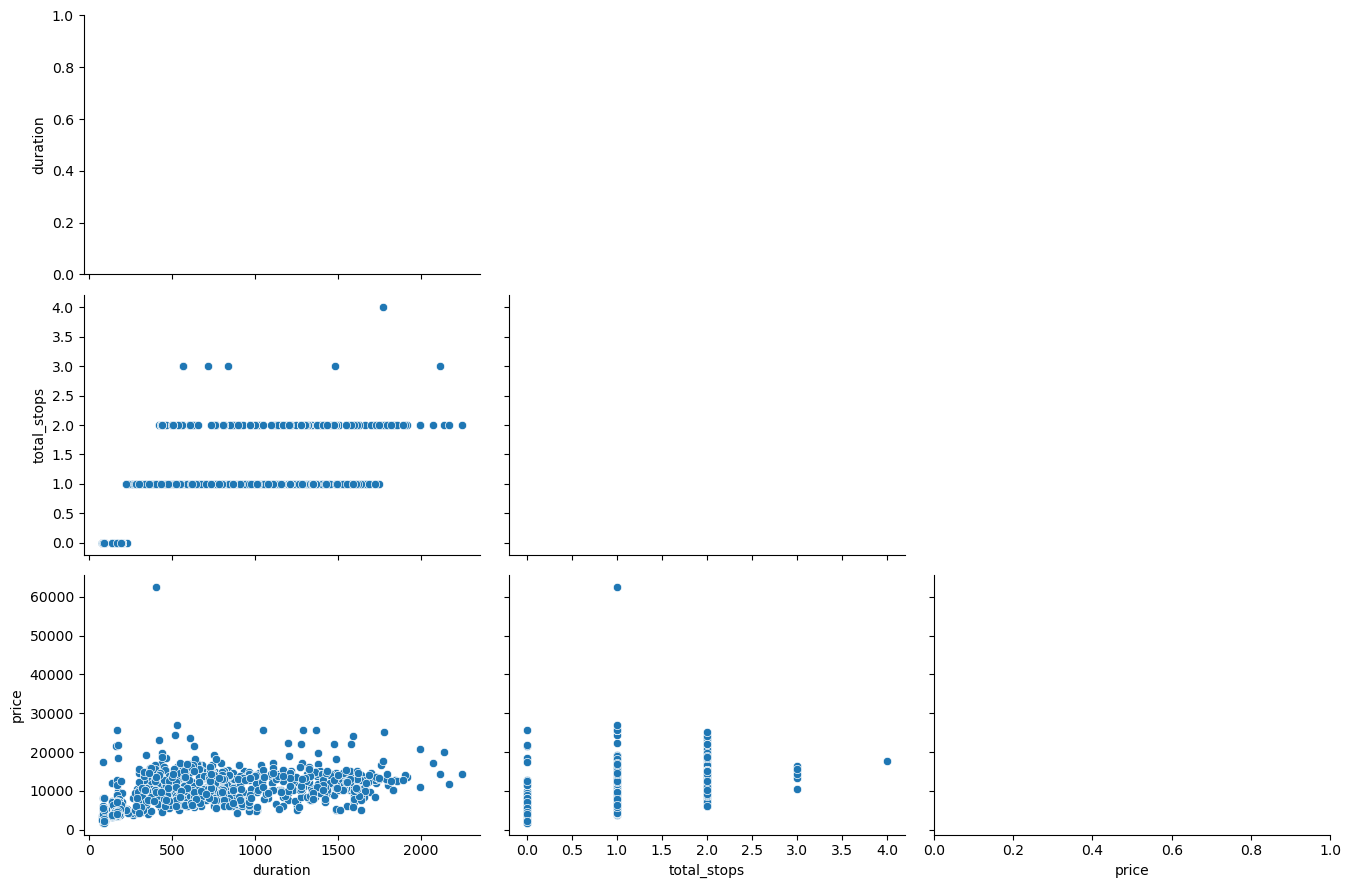

In [17]:
pair_plots(train)

In [18]:
def rotate_xlabels(ax, angle=35):
  ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=angle,
        ha="right"
    )
  

def rotate_ylabels(ax, angle=0):
  ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=angle
  )

In [19]:
def correlation_heatmap(data,
                        figsize=(12, 6),
                        method="spearman",
                        cmap="RdBu"):
  cm = data.corr(method=method, numeric_only=True)

  mask = np.zeros_like(cm, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      cm,
      vmin=-1,
      vmax=1,
      cmap=cmap,
      center=0,
      annot=True,
      fmt=".2f",
      linewidths=1.5,
      square=True,
      mask=mask,
      ax=ax
  )
  rotate_xlabels(ax)
  rotate_ylabels(ax)
  ax.set(title=f"{method.title()} Correlation Matrix Heatmap")

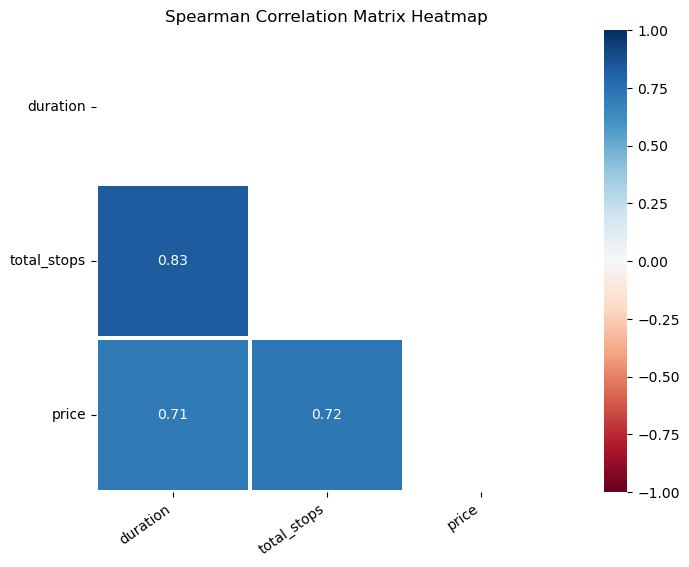

In [20]:
correlation_heatmap(train)

In [21]:
def cramers_v(data, var1, var2):
  ct = pd.crosstab(
      data.loc[:, var1],
      data.loc[:, var2]
  )
  r, c = ct.shape
  n = ct.sum().sum()
  chi2 = stats.chi2_contingency(ct).statistic
  phi2 = chi2 / n

  # bias correction
  phi2_ = max(0, phi2 - ((r - 1) * (c - 1) / (n - 1)))
  r_ = r - (((r - 1) ** 2) / (n - 1))
  c_ = c - (((c - 1) ** 2) / (n - 1))

  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))

In [22]:
def cramersV_heatmap(data, figsize=(12, 6), cmap="Blues"):
  cols = data.select_dtypes(include="O").columns.to_list()

  matrix = (
      pd
      .DataFrame(data=np.ones((len(cols), len(cols))))
      .set_axis(cols, axis=0)
      .set_axis(cols, axis=1)
  )

  for col1 in cols:
    for col2 in cols:
      if col1 != col2:
        matrix.loc[col1, col2] = cramers_v(data, col1, col2)

  mask = np.zeros_like(matrix, dtype=bool)
  mask[np.triu_indices_from(mask)] = True
  
  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      matrix,
      vmin=0,
      vmax=1,
      cmap=cmap,
      annot=True,
      fmt=".2f",
      square=True,
      linewidths=1.5,
      mask=mask,
      ax=ax
  )
  ax.set(title="Cramer's V Correlation Matrix Heatmap")
  rotate_xlabels(ax)
  rotate_ylabels(ax)

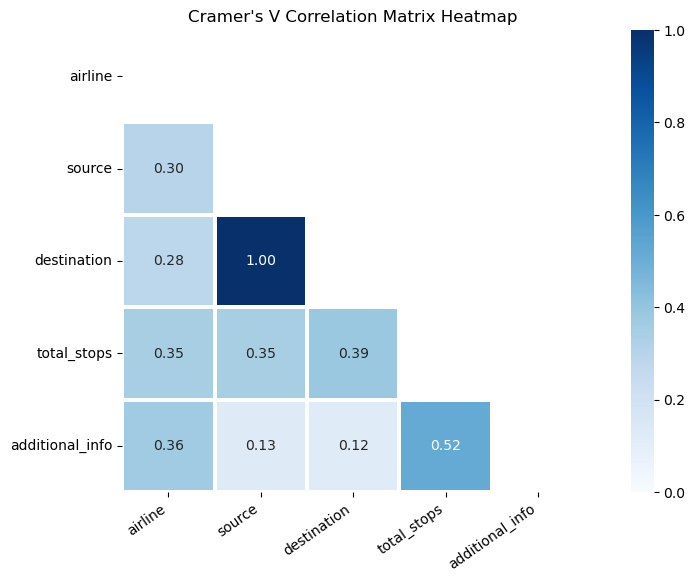

In [23]:
cramersV_heatmap(train.assign(total_stops=train["total_stops"].astype(object)))

## Detailed Analysis

In [24]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 1. Airline

In [25]:
train.airline

0                  Indigo
1                Spicejet
2                  Indigo
3             Jet Airways
4             Jet Airways
              ...        
1275          Jet Airways
1276          Jet Airways
1277          Jet Airways
1278    Multiple Carriers
1279    Multiple Carriers
Name: airline, Length: 1280, dtype: object

In [26]:
def cat_summary(data, var):
  import warnings
  warnings.filterwarnings("ignore")

  # title
  col = data.loc[:, var].copy()
  display_html(2, var)

  # quick glance
  display_html(3, "Quick Glance:")
  display(col)

  # meta-data
  display_html(3, "Meta-data:")
  print(f"{'Data Type':15}: {col.dtype}")
  print(f"{'Cardinality':15}: {col.nunique(dropna=True)} categories")
  print(f"{'Missing Data':15}: {col.isna().sum():,} rows ({col.isna().mean() * 100:.2f} %)")
  print(f"{'Available Data':15}: {col.count():,} / {len(col):,} rows")

  # summary
  display_html(3, "Summary:")
  display(
      col
      .describe()
      .rename("")
      .to_frame()
  )

  # categories
  display_html(3, "Categories Distribution:")
  with pd.option_context("display.max_rows", None):
    display(
        col
        .value_counts()
        .pipe(lambda ser: pd.concat(
            [
                ser,
                col.value_counts(normalize=True)
            ],
            axis=1
        ))
        .set_axis(["count", "percentage"], axis=1)
        .rename_axis(index="category")
    )


In [27]:
cat_summary(train, "airline")

0                  Indigo
1                Spicejet
2                  Indigo
3             Jet Airways
4             Jet Airways
              ...        
1275          Jet Airways
1276          Jet Airways
1277          Jet Airways
1278    Multiple Carriers
1279    Multiple Carriers
Name: airline, Length: 1280, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 1,280 / 1,280 rows


,
count,1280
unique,8
top,Jet Airways
freq,439


,count,percentage
category,,
Jet Airways,439,0.342969
Indigo,253,0.197656
Air India,211,0.164844
Multiple Carriers,162,0.126562
Spicejet,95,0.074219
Vistara,64,0.050000
Air Asia,33,0.025781
Goair,23,0.017969


In [28]:
def pie_chart(counts, colors, ax):
  pie = ax.pie(
        counts.values,
        labels=counts.index,
        autopct="%.2f%%",
        colors=colors,
        wedgeprops=dict(alpha=0.7, edgecolor="black"),
  )

  ax.set_title("Pie Chart")

  ax.legend(
      loc="upper left",
      bbox_to_anchor=(1.02, 1),
      title="Categories",
      title_fontproperties=dict(weight="bold", size=10)
  )

  plt.setp(
      pie[2],
      weight="bold",
      color="white"
  )


In [29]:
def bar_chart(counts, colors, ax):
  barplot = ax.bar(
        x=range(len(counts)),
        height=counts.values,
        tick_label=counts.index,
        color=colors,
        edgecolor="black",
        alpha=0.7
  )

  ax.bar_label(
      barplot,
      padding=5,
      color="black"
  )

  ax.set(
      title="Bar Chart",
      xlabel="Categories",
      ylabel="Count"
  )

  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      ha="right"
  )


In [30]:
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud, STOPWORDS

In [31]:
def cat_univar_plots(data,
                     var,
                     k=None,
                     order=None,
                     show_wordcloud=True,
                     figsize=(12, 8.5)):
  display_html(2, f"Univariate Analysis of {var}")
  display_html(content="")

  fig = plt.figure(figsize=figsize)
  gs = GridSpec(2, 2, figure=fig)
  ax1 = fig.add_subplot(gs[0, 0]) # bar-chart
  ax2 = fig.add_subplot(gs[0, 1]) # pie-chart
  ax3 = fig.add_subplot(gs[1, :]) # word-cloud

  if k is None:
    counts = (
        data
        .loc[:, var]
        .value_counts()
        .reindex(index=order)
    )
  else:
    temp = get_top_k(
        data,
        var,
        k=k
    )
    counts = (
        temp
        .loc[:, var]
        .value_counts()
    )

  colors = [tuple(np.random.choice(256, size=3) / 255) for _ in range(len(counts))]

  # bar-chart
  bar_chart(
      counts,
      colors,
      ax1
  )

  # pie_chart
  pie_chart(
      counts,
      colors,
      ax2
  )

  # word-cloud
  if show_wordcloud:
    var_string = " ".join(
        data
        .loc[:, var]
        .dropna()
        .str.replace(" ", "_")
        .to_list()
    )

    word_cloud = WordCloud(
        width=2000,
        height=700,
        random_state=42,
        background_color="black",
        colormap="Set2",
        stopwords=STOPWORDS
    ).generate(var_string)

    ax3.imshow(word_cloud)
    ax3.axis("off")
    ax3.set_title("Word Cloud")
  else:
    ax3.remove()

  plt.tight_layout()
  plt.show()


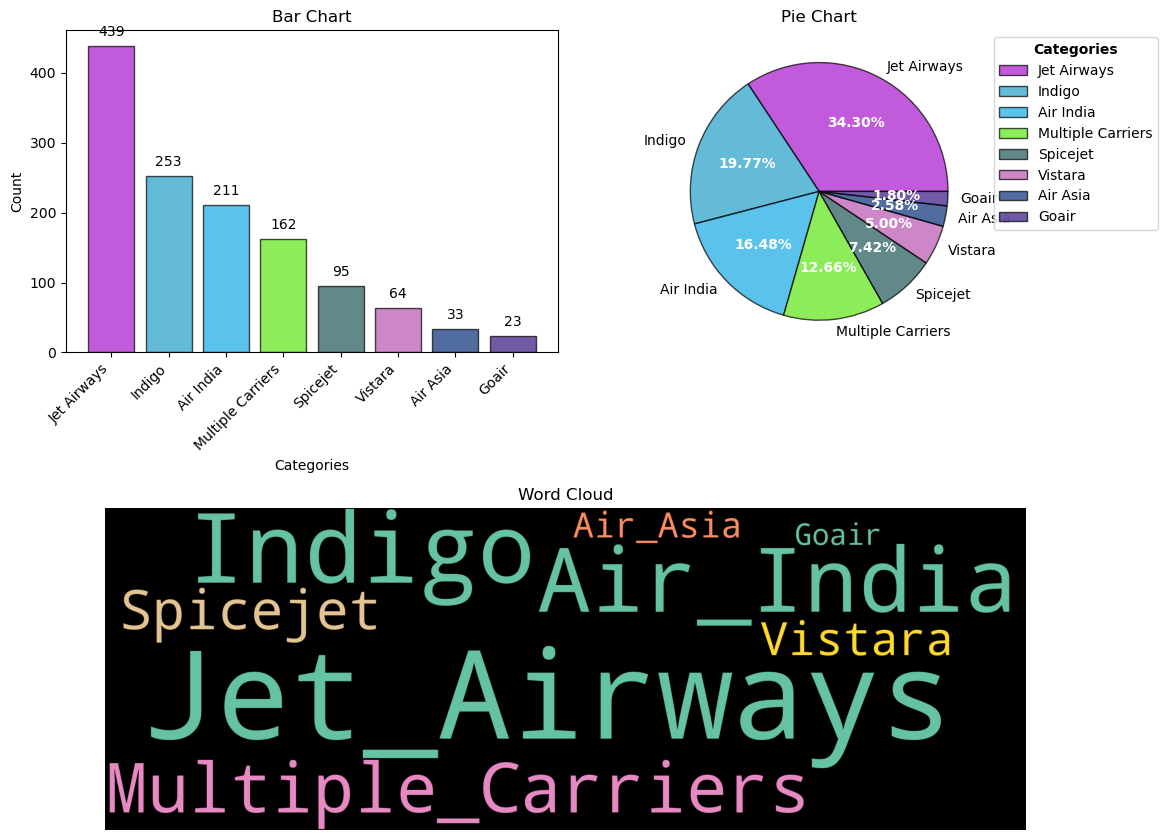

In [32]:
cat_univar_plots(train, "airline")

In [33]:
def num_cat_bivar_plots(data,
                        num_var,
                        cat_var,
                        k=None,
                        estimator="mean",
                        orient="v",
                        order=None,
                        figsize=(15, 4)):

  def get_values(data,
                 num_var,
                 cat_var,
                 estimator,
                 order=None):
    return (
        data
        .groupby(cat_var)
        .agg(estimator, numeric_only=True)
        .loc[:, num_var]
        .dropna()
        .sort_values()
        .reindex(index=order)
    )

  import warnings
  warnings.filterwarnings("ignore")

  display_html(2, f"Bi-variate Analysis between {cat_var} and {num_var}")
  display_html(content="")

  if k is None:
    temp = get_values(
        data,
        num_var,
        cat_var,
        estimator,
        order=order
    )
  else:
    data = get_top_k(
        data,
        cat_var,
        k=k
    )
    temp = get_values(
        data,
        num_var,
        cat_var,
        estimator
    )

  if orient == "v":
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # bar plot
    bar = sns.barplot(
      x=temp.index,
      y=temp.values,
      color="#d92b2b",
      ax=axes[0],
      edgecolor="black",
      alpha=0.5
    )
    axes[0].set(
        title="Bar Plot",
        xlabel=cat_var,
        ylabel=num_var
    )
    rotate_xlabels(axes[0])

    # box plot
    sns.boxplot(
      data,
      x=cat_var,
      y=num_var,
      color="lightgreen",
      order=temp.index,
      ax=axes[1]
    )
    axes[1].set(
        title="Box Plot",
        xlabel=cat_var,
        ylabel=""
    )
    rotate_xlabels(axes[1])

    # violin plot
    sns.violinplot(
      data,
      x=cat_var,
      y=num_var,
      color="#0630c9",
      order=temp.index,
      ax=axes[2],
      alpha=0.5
    )
    axes[2].set(
        title="Violin Plot",
        xlabel=cat_var,
        ylabel=""
    )
    rotate_xlabels(axes[2])
  else:
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # bar plot
    bar = sns.barplot(
      y=temp.index,
      x=temp.values,
      color="#d92b2b",
      ax=axes[0],
      edgecolor="black",
      alpha=0.5
    )
    axes[0].set(
        title="Bar Plot",
        xlabel="",
        ylabel=cat_var
    )

    # box plot
    sns.boxplot(
      data,
      y=cat_var,
      x=num_var,
      color="lightgreen",
      order=temp.index,
      ax=axes[1]
    )
    axes[1].set(
        title="Box Plot",
        xlabel="",
        ylabel=cat_var
    )

    # violin plot
    sns.violinplot(
      data,
      y=cat_var,
      x=num_var,
      color="#0630c9",
      order=temp.index,
      ax=axes[2],
      alpha=0.5
    )
    axes[2].set(
        title="Violin Plot",
        xlabel=num_var,
        ylabel=cat_var
    )

  plt.tight_layout()
  plt.show()

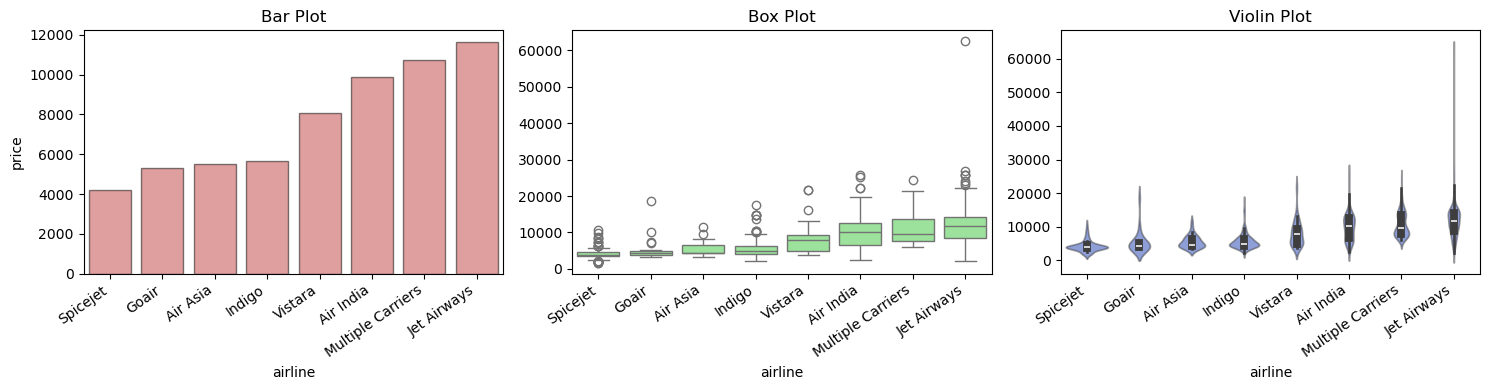

In [34]:
num_cat_bivar_plots(data=train, num_var="price", cat_var="airline")

In [35]:
def num_cat_hyp_testing(data, num_var, cat_var, alpha=0.05):
  display_html(2, f"Hypothesis Test for Association between {num_var} and {cat_var}")

  groups_df = (
      data
      .dropna(subset=[num_var])
      .groupby(cat_var)
  )
  groups = [group[num_var].values for _, group in groups_df]

  # anova test
  anova = stats.f_oneway(*groups)
  statistic = anova[0]
  pvalue = anova[1]
  display_html(3, "ANOVA Test")
  print(f"- {'Significance Level':21}: {alpha * 100}%")
  print(f"- {'Null Hypothesis':21}: The groups have similar population mean")
  print(f"- {'Alternate Hypothesis':21}: The groups don't have similar population mean")
  print(f"- {'Test Statistic':21}: {statistic}")
  print(f"- {'p-value':21}: {pvalue}")
  if pvalue < alpha:
    print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {num_var} and {cat_var} are associated to each other")
  else:
    print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {num_var} and {cat_var} are not associated to each other")

  # kruskal-wallis test
  kruskal = stats.kruskal(*groups)
  statistic = kruskal[0]
  pvalue = kruskal[1]
  display_html(3, "Kruskal-Wallis Test")
  print(f"- {'Significance Level':21}: {alpha * 100}%")
  print(f"- {'Null Hypothesis':21}: The groups have similar population median")
  print(f"- {'Alternate Hypothesis':21}: The groups don't have similar population median")
  print(f"- {'Test Statistic':21}: {statistic}")
  print(f"- {'p-value':21}: {pvalue}")
  if pvalue < alpha:
    print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {num_var} and {cat_var} are associated to each other")
  else:
    print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {num_var} and {cat_var} are not associated to each other")


In [36]:
num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 97.17820138869587
- p-value              : 1.0524555986211408e-113
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 573.647474356216
- p-value              : 1.1489041991077776e-119
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


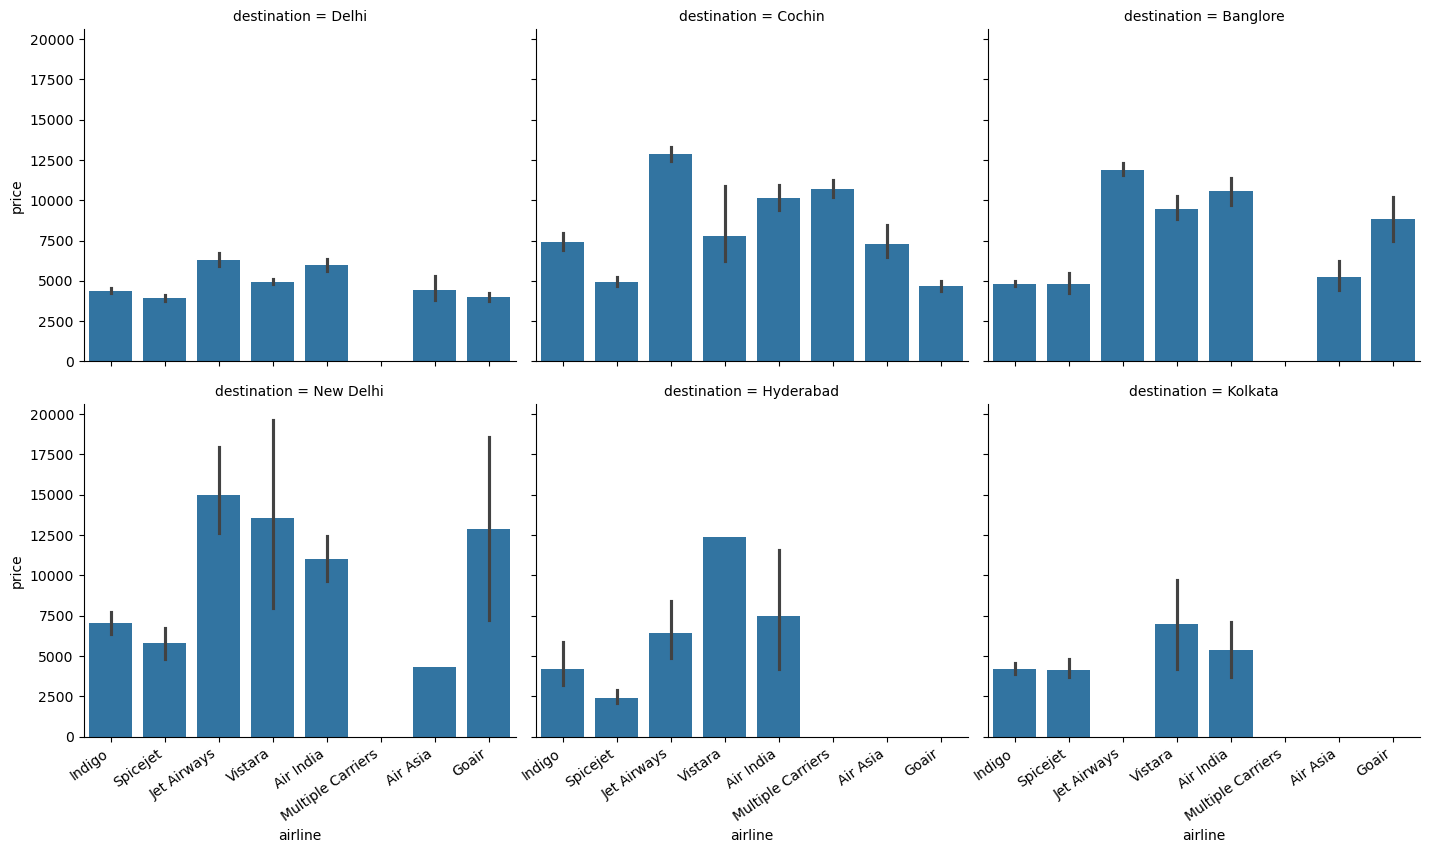

In [37]:
airline_grid = sns.FacetGrid(data=train,
                            col="destination",
                            col_wrap=3,
                            height=4,
                            aspect=1.2,
                            sharey=True)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())
for ax in airline_grid.axes[3:]:
    rotate_xlabels(ax)

## 2. Date of Journey

In [38]:
train.date_of_journey

0      2019-06-24
1      2019-06-09
2      2019-06-15
3      2019-05-01
4      2019-03-24
          ...    
1275   2019-05-06
1276   2019-05-01
1277   2019-06-03
1278   2019-05-18
1279   2019-03-27
Name: date_of_journey, Length: 1280, dtype: datetime64[ns]

In [39]:
def dt_univar_plots(data, var, target=None, bins="auto"):
  display_html(3, f"Univariate plots of {var}")
  col = data.loc[:, var].copy()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

  # histogram
  sns.histplot(
    data=data,
    x=var,
    bins=bins,
    color="#1973bd",
    ax=ax1
  )
  sns.rugplot(
    data=data,
    x=var,
    color="darkblue",
    height=0.035,
    ax=ax1
  )
  ax1.set(title="Histogram")
  rotate_xlabels(ax1)

  # line-plot
  sns.lineplot(
    data=data,
    x=var,
    y=target,
    color="#d92b2b",
    ax=ax2
  )
  rotate_xlabels(ax2)
  ax2.set(title="Line Plot")

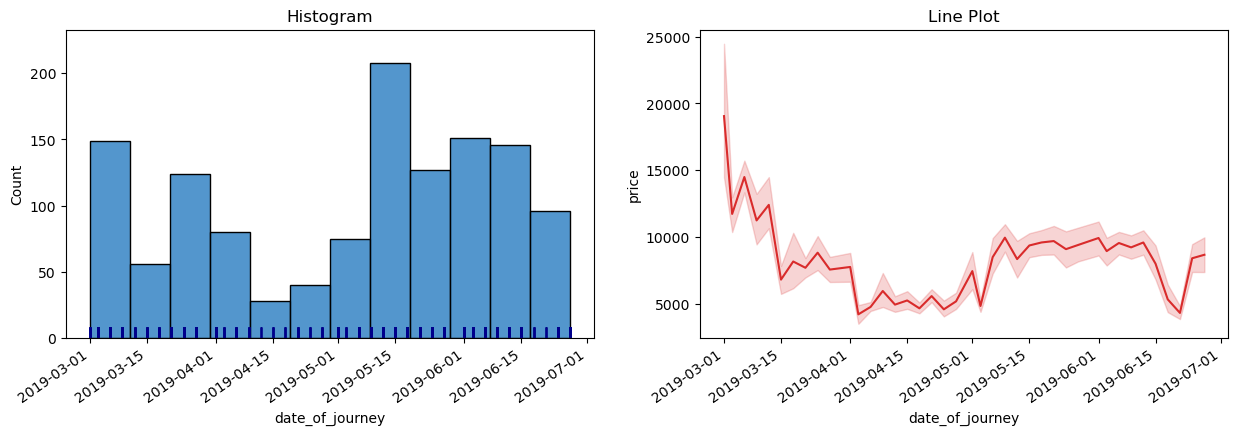

In [40]:
dt_univar_plots(data=train, var="date_of_journey", target="price")

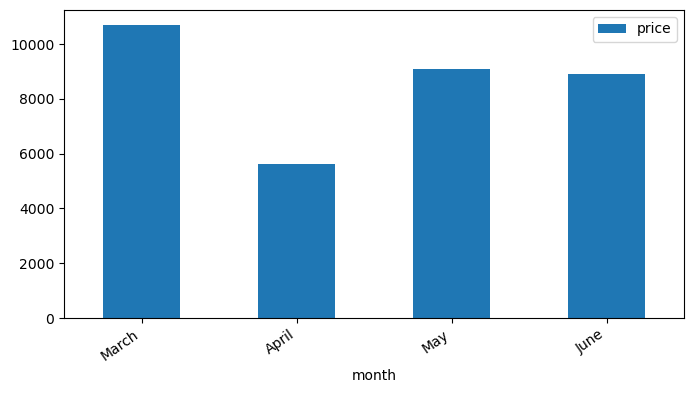

In [41]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="M"))
    .price.mean()
    .to_frame()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(8,4)
    )
)

ax = plt.gca()
rotate_xlabels(ax)

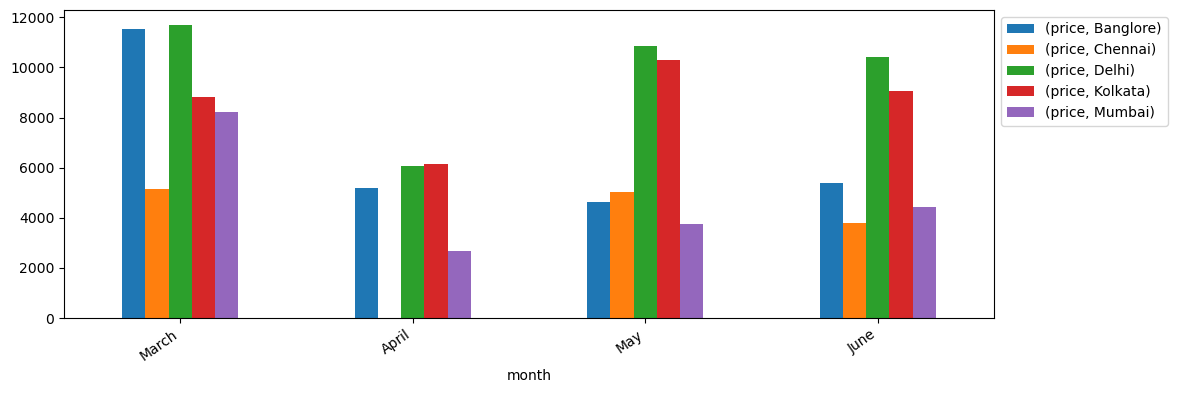

In [42]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
    .price.mean()
    .to_frame()
    .unstack(fill_value=0)
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(12,4)
    )
)

ax = plt.gca()
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

rotate_xlabels(ax)

## 3. Departure Time

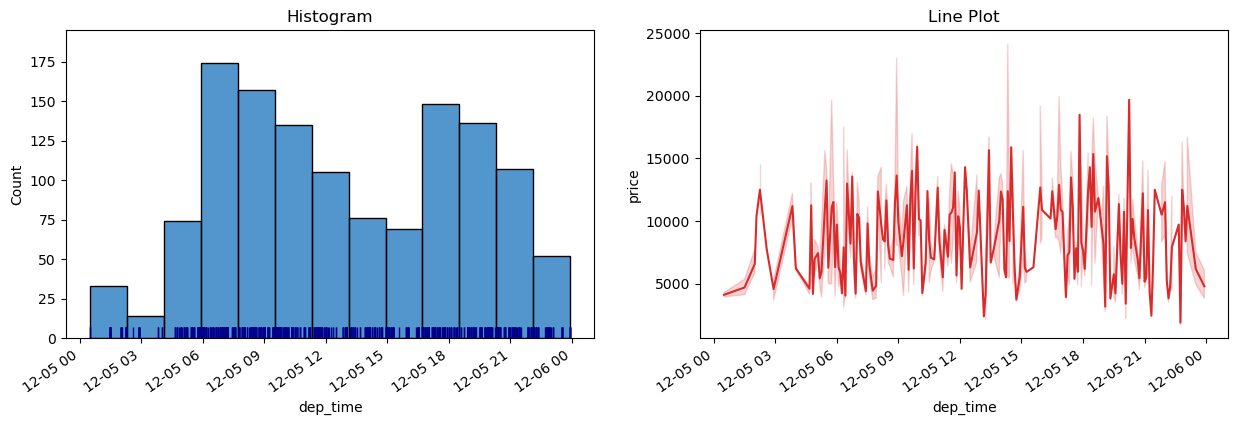

In [43]:
dt_univar_plots(train, "dep_time", "price")

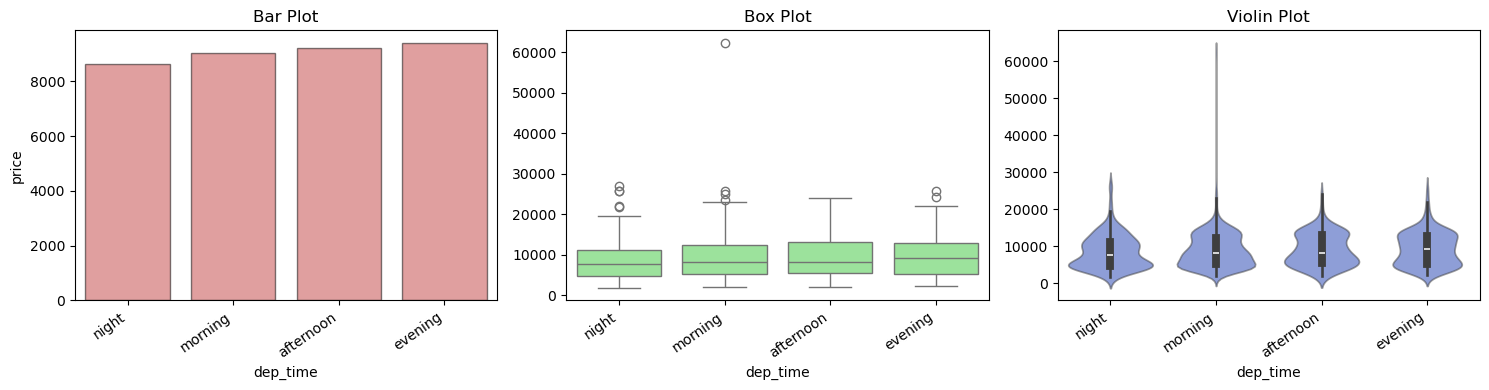

In [44]:
(
    train
    .assign(dep_time = lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
                  df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
                  df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
                 ["morning", "afternoon", "evening"],
                 default="night")
    ))
    .pipe(num_cat_bivar_plots, "price", "dep_time")
)

## 4. Duration

In [45]:
train.duration

0        180
1        315
2        665
3        570
4       1410
        ... 
1275     735
1276      90
1277     360
1278     645
1279     620
Name: duration, Length: 1280, dtype: int64

In [46]:
def num_summary(data, var):
  import warnings
  warnings.filterwarnings("ignore")

  # title
  col = data.loc[:, var].copy()
  display_html(size=2, content=var)

  # quick glance
  display_html(3, "Quick Glance:")
  display(col)

  # meta-data
  display_html(3, "Meta-data:")
  print(f"{'Data Type':15}: {col.dtype}")
  print(f"{'Missing Data':15}: {col.isna().sum():,} rows ({col.isna().mean() * 100:.2f} %)")
  print(f"{'Available Data':15}: {col.count():,} / {len(col):,} rows")

  # quantiles
  display_html(3, "Percentiles:")
  display(
      col
      .quantile([0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])
      .rename(index=lambda val: f"{val * 100:.0f}")
      .rename("value")
      .rename_axis(index="percentile")
      .to_frame()
  )

  # central tendancy
  display_html(3, "Central Tendancy:")
  display(
      pd
      .Series({"mean": col.mean(),
               "trimmed mean (5%)": stats.trim_mean(col.values, 0.05),
               "trimmed mean (10%)": stats.trim_mean(col.values, 0.1),
               "median": col.median()})
      .rename("value")
      .to_frame()
  )

  # spread
  display_html(3, "Measure of Spread:")
  std = col.std()
  iqr = col.quantile(0.75) - col.quantile(0.25)
  display(
      pd
      .Series({
          "var": col.var(),
          "std": std,
          "IQR": iqr,
          "mad": stats.median_abs_deviation(col.dropna()),
          "coef_variance": std / col.mean()
      })
      .rename("value")
      .to_frame()
  )

  # skewness and kurtosis
  display_html(3, "Skewness and Kurtosis:")
  display(
      pd
      .Series({
          "skewness": col.skew(),
          "kurtosis": col.kurtosis()
      })
      .rename("value")
      .to_frame()
  )

  alpha = 0.05
  # test for normality
  display_html(3, "Hypothesis Testing for Normality:")
  # shapiro-wilk test
  display_html(4, "Shapiro-Wilk Test:")
  sw_test = stats.shapiro(col.dropna().values)
  sw_statistic = sw_test.statistic
  sw_pvalue = sw_test.pvalue
  print(f"{'Significance Level':21}: {alpha}")
  print(f"{'Null Hypothesis':21}: The data is normally distributed")
  print(f"{'Alternate Hypothesis':21}: The data is not normally distributed")
  print(f"{'p-value':21}: {sw_pvalue}")
  print(f"{'Test Statistic':21}: {sw_statistic}")
  if sw_pvalue < alpha:
    print(f"- Since p-value is less than alpha ({alpha}), we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print("- CONCLUSION: We conclude that the data sample is not normally distributed")
  else:
    print(f"- Since p-value is greater than alpha ({alpha}), we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print("- CONCLUSION: We conclude that the data sample is normally distributed")

  #anderson-darling test
  display_html(4, "Anderson-Darling Test:")
  ad_test = stats.anderson(col.dropna().values, dist="norm")
  ad_statistic = ad_test.statistic
  ad_critical = ad_test.critical_values[2]
  print(f"{'Significance Level':21}: {alpha}")
  print(f"{'Null Hypothesis':21}: The data is normally distributed")
  print(f"{'Alternate Hypothesis':21}: The data is not normally distributed")
  print(f"{'Critical Value':21}: {ad_critical}")
  print(f"{'Test Statistic':21}: {ad_statistic}")
  if ad_statistic >= ad_critical:
    print(f"- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print("- CONCLUSION: We conclude that the data sample is not normally distributed")
  else:
    print(f"- Since the Test-statistic is less than Critical Value, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print("- CONCLUSION: We conclude that the data sample is normally distributed")


In [47]:
num_summary(train, "duration")

0        180
1        315
2        665
3        570
4       1410
        ... 
1275     735
1276      90
1277     360
1278     645
1279     620
Name: duration, Length: 1280, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 1,280 / 1,280 rows


,value
percentile,
0,75.0
5,90.0
10,150.0
25,170.0
50,520.0
75,925.0
90,1441.0
95,1595.5
99,1832.1


,value
mean,632.796875
trimmed mean (5%),600.833333
trimmed mean (10%),571.850586
median,520.000000


,value
var,249075.204994
std,499.074348
IQR,755.000000
mad,350.000000
coef_variance,0.788680


,value
skewness,0.827723
kurtosis,-0.368104


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 9.665872081189322e-30
Test Statistic       : 0.8855111681588278
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.785
Test Statistic       : 49.05151728175656
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [48]:
def num_univar_plots(data, var, bins=10, figsize=(15, 7)):
  display_html(2, f"Univariate Analysis of {var}")
  display_html(content="")
  col = data.loc[:, var].copy()

  fig, axes = plt.subplots(2, 3, figsize=figsize)
  axes = axes.ravel()

  #histogram
  sns.histplot(
      data,
      x=var,
      bins=bins,
      kde=True,
      color="#1973bd",
      ax=axes[0],
  )
  sns.rugplot(
      data,
      x=var,
      color="black",
      height=0.035,
      ax=axes[0]
  )
  axes[0].set(title="Histogram")

  # cdf
  sns.ecdfplot(
      data,
      x=var,
      ax=axes[1],
      color="red"
  )
  axes[1].set(title="CDF")

  # power transform
  data = data.assign(**{
      f"{var}_pwt": (
          PowerTransformer()
          .fit_transform(data.loc[:, [var]])
          .ravel()
      )
  })
  sns.kdeplot(
      data,
      x=f"{var}_pwt",
      fill=True,
      color="#f2b02c",
      ax=axes[2]
  )
  sns.rugplot(
      data,
      x=f"{var}_pwt",
      color="black",
      height=0.035,
      ax=axes[2]
  )
  axes[2].set(title="Power Transformed")

  # box plot
  sns.boxplot(
      data,
      x=var,
      color="#4cd138",
      ax=axes[3]
  )
  axes[3].set(title="Box Plot")

  # violin plot
  sns.violinplot(
      data,
      x=var,
      color="#ed68b4",
      ax=axes[4]
  )
  axes[4].set(title="Violin Plot")

  # qq plot
  sm.qqplot(
      col.dropna(),
      line="45",
      fit=True,
      ax=axes[5]
  )
  axes[5].set(title="QQ Plot")

  plt.tight_layout()
  plt.show()


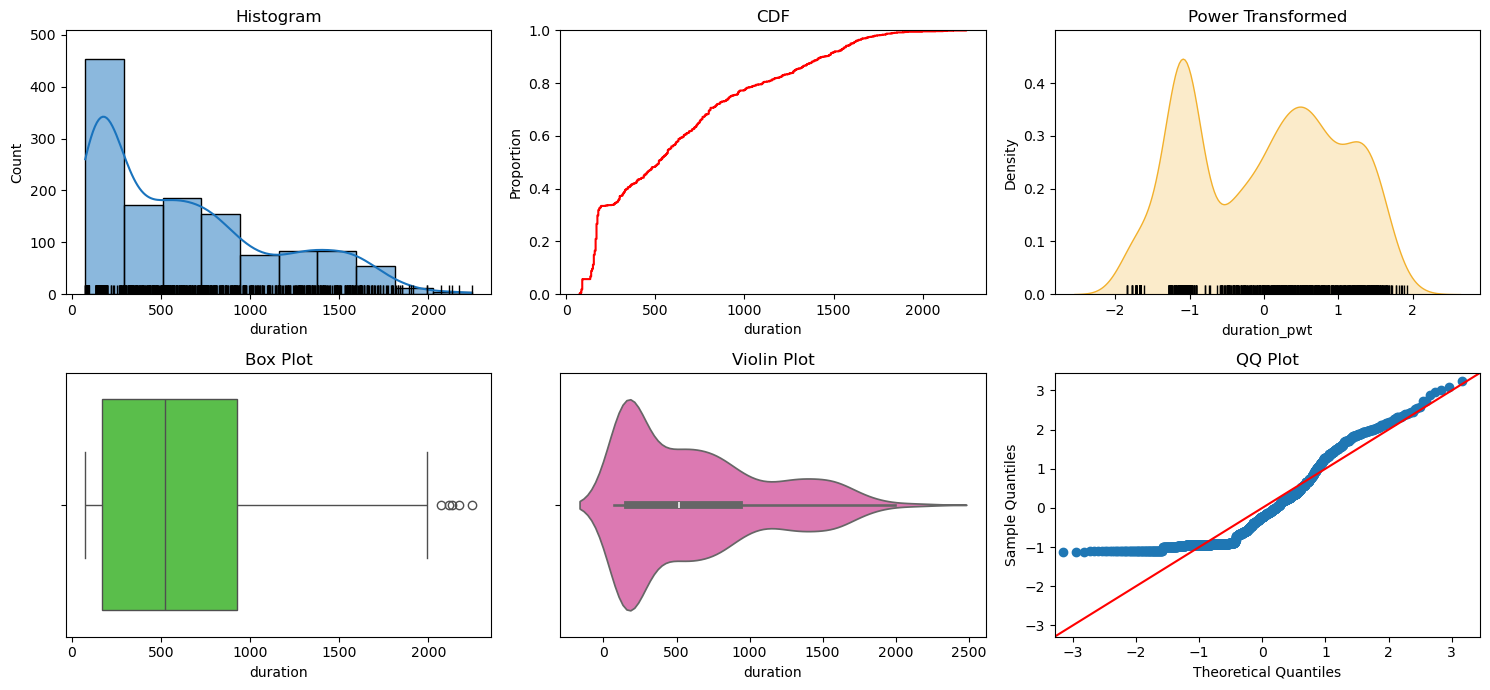

In [49]:
num_univar_plots(train, "duration")

In [50]:
def num_bivar_plots(data, var_x, var_y, figsize=(12, 4.5), scatter_kwargs=dict(), hexbin_kwargs=dict()):
  display_html(2, f"Bi-variate Analysis between {var_x} and {var_y}")
  display_html(content="")

  fig, axes = plt.subplots(1, 2, figsize=figsize)

  # scatter plot
  sns.scatterplot(
      data,
      x=var_x,
      y=var_y,
      ax=axes[0],
      edgecolors="black",
      **scatter_kwargs
  )
  axes[0].set(title="Scatter Plot")

  # hexbin plot
  col_x = data.loc[:, var_x]
  col_y = data.loc[:, var_y]
  hexbin = axes[1].hexbin(
      x=col_x,
      y=col_y,
      **hexbin_kwargs
  )
  axes[1].set(
      title="Hexbin Plot",
      xlabel=var_x,
      xlim=(col_x.min(), col_x.max()),
      ylim=(col_y.min(), col_y.max())
  )
  cb = plt.colorbar(
      hexbin,
      label="Count"
  )

  plt.tight_layout()
  plt.show()


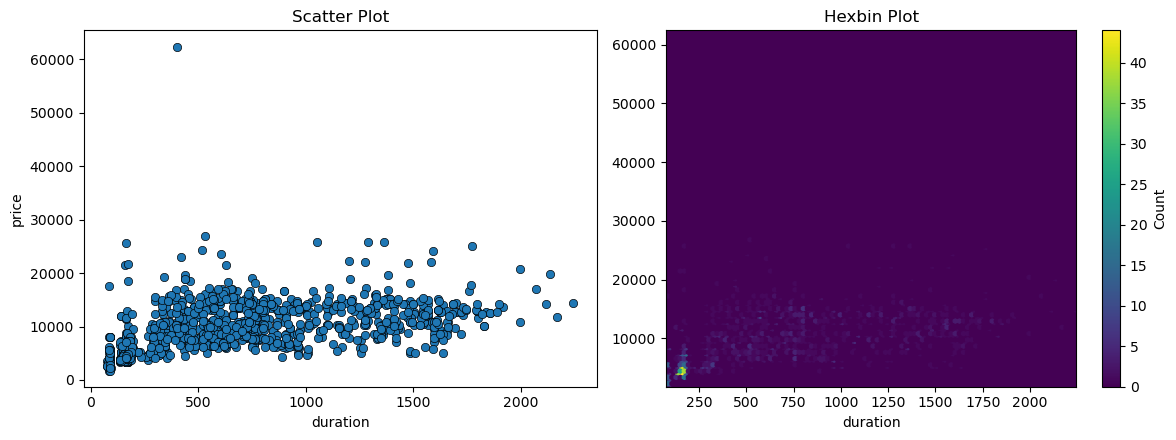

In [51]:
num_bivar_plots(train, "duration", "price")

In [52]:
def num_num_hyp_testing(data, var1, var2, alpha=0.05):
  display_html(2, f"Hypothesis Test for Association between {var1} and {var2}")

  temp = (
      data
      .dropna(subset=[var1, var2], how="any")
      .copy()
  )

  # pearson test
  pearson = stats.pearsonr(temp[var1].values, temp[var2].values)
  pvalue = pearson.pvalue
  statistic = pearson.statistic
  display_html(3, "Pearson Test")
  print(f"- {'Significance Level':21}: {alpha * 100}%")
  print(f"- {'Null Hypothesis':21}: The samples are uncorrelated")
  print(f"- {'Alternate Hypothesis':21}: The samples are correlated")
  print(f"- {'Test Statistic':21}: {statistic}")
  print(f"- {'p-value':21}: {pvalue}")
  if pvalue < alpha:
    print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {var1} and {var2} are correlated")
  else:
    print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {var1} and {var2} are uncorrelated")

  # spearman test
  spearman = stats.spearmanr(temp[var1].values, temp[var2].values)
  pvalue = spearman.pvalue
  statistic = spearman.statistic
  display_html(3, "Spearman Test")
  print(f"- {'Significance Level':21}: {alpha * 100}%")
  print(f"- {'Null Hypothesis':21}: The samples are uncorrelated")
  print(f"- {'Alternate Hypothesis':21}: The samples are correlated")
  print(f"- {'Test Statistic':21}: {statistic}")
  print(f"- {'p-value':21}: {pvalue}")
  if pvalue < alpha:
    print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {var1} and {var2} are correlated")
  else:
    print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
    print(f"- CONCLUSION: The variables {var1} and {var2} are uncorrelated")


In [53]:
num_num_hyp_testing(train, "duration", "price")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5446577297033206
- p-value              : 8.983438539769456e-100
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.707082187173786
- p-value              : 1.4451649150067496e-194
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


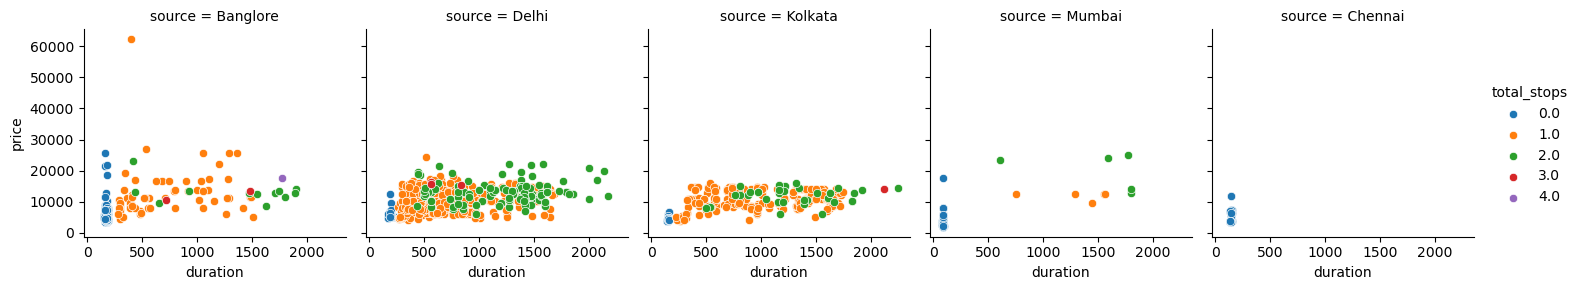

In [54]:
duration_grid = sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops",
    sharey=2
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [ ]:
## Automated EDA

In [55]:
# !pip install ydata_profiling

In [56]:
# from ydata_profiling import ProfileReport

In [57]:
# report = ProfileReport(train)
# report.to_file(output_file="output.html")

Export report to file: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.64it/s]


In [59]:
def get_iqr_outliers(data, var, band=1.5):
    q1, q3 = (
      data
      .loc[:, var]
      .quantile([0.25, 0.75])
      .values
    )

    iqr = q3 - q1
    lower_limit = q1 - (band * iqr)
    upper_limit = q3 + (band * iqr)

    display_html(3, f"{var} - IQR Limits:")
    print(f"{'Lower Limit':12}: {lower_limit}")
    print(f"{'Upper Limit':12}: {upper_limit}")

    return (
      data
      .query(f"{var} > @upper_limit | {var} < @lower_limit")
      .sort_values(var)
    )

In [60]:
get_iqr_outliers(train, "duration")

Lower Limit : -962.5
Upper Limit : 2057.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
89,Jet Airways,2019-03-06,Delhi,Cochin,2024-12-05 17:55:00,2024-12-05 04:25:00,2070,2.0,No Info,17072
648,Air India,2019-03-24,Kolkata,Banglore,2024-12-05 12:00:00,2024-12-05 23:15:00,2115,3.0,No Info,14221
174,Jet Airways,2019-03-06,Delhi,Cochin,2024-12-05 16:50:00,2024-12-05 04:25:00,2135,2.0,No Info,19907
913,Air India,2019-03-09,Delhi,Cochin,2024-12-05 07:05:00,2024-12-05 19:15:00,2170,2.0,No Info,11762
396,Air India,2019-03-24,Kolkata,Banglore,2024-12-05 09:50:00,2024-12-05 23:15:00,2245,2.0,No Info,14410
